In [1]:
import pandas as pd

train_data = pd.read_csv('SkinCancerTrain.csv')
test_data = pd.read_csv("SkinCancerTestNoY.csv")


Lasso Selection Results: 
Original Features: 182
Selected Features: 140
                        Feature  Coefficient
0                           age     0.285019
2                  avg_daily_uv     0.127684
50          skin_tone_Very Fair     0.120300
100   family_history_1st-degree     0.120281
105        immunosuppressed_Yes     0.119993
12            number_of_lesions     0.110970
102      family_history_Unknown    -0.110601
46               skin_tone_Fair     0.106521
71         sunscreen_freq_Often    -0.101412
15           sunburns_last_year     0.100515
4                   outdoor_job     0.078722
69        sunscreen_freq_Always    -0.074930
154  skin_photosensitivity_High     0.057457
44              skin_tone_Brown    -0.056258
97        tanning_bed_use_Often     0.055274


C:\Users\ryanl\AppData\Local\Temp\ipykernel_9508\1594127488.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=selected_features.head(20), palette='coolwarm')


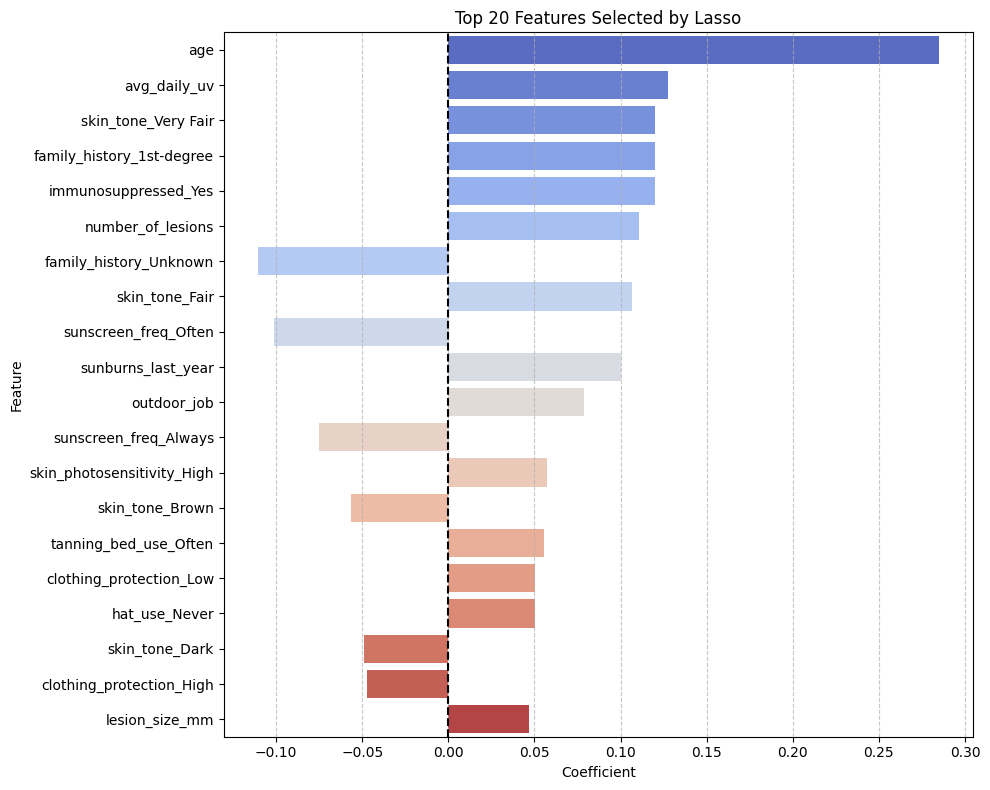

['age', 'avg_daily_uv', 'skin_tone_Very Fair', 'family_history_1st-degree', 'immunosuppressed_Yes', 'number_of_lesions', 'family_history_Unknown', 'skin_tone_Fair', 'sunscreen_freq_Often', 'sunburns_last_year', 'outdoor_job', 'sunscreen_freq_Always', 'skin_photosensitivity_High', 'skin_tone_Brown', 'tanning_bed_use_Often', 'clothing_protection_Low', 'hat_use_Never', 'skin_tone_Dark', 'clothing_protection_High', 'lesion_size_mm', 'sunscreen_freq_Rarely', 'tanning_bed_use_Never', 'hat_use_Always', 'sunburns_last_year_missing_flag', 'number_of_lesions_missing_flag', 'skin_tone_Olive', 'skin_photosensitivity_Moderate', 'skin_tone_Unknown', 'sunscreen_freq_Unknown', 'sunscreen_freq_Never', 'tanning_bed_use_Occasionally', 'immunosuppressed_No', 'favorite_cuisine_Italian', 'years_lived_at_address', 'lesion_location_Torso', 'avg_daily_uv_missing_flag', 'participates_outdoor_sports_Unknown', 'zip_code_last_digit_missing_flag', 'music_genre_Pop', 'skin_photosensitivity_Low', 'clothing_protection

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


train_raw = pd.read_csv('SkinCancerTrain.csv')

X = train_raw.drop(columns=['ID', 'Cancer'])
y = train_raw['Cancer'].apply(lambda x: 1 if x == 'Malignant' else 0)


numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    if X[col].isnull().any():
        X[f'{col}_missing_flag'] = X[col].isnull().astype(int)
        X[col] = X[col].fillna(X[col].median())

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
X[categorical_cols] = X[categorical_cols].fillna("Unknown")

X_encoded = pd.get_dummies(X, columns=categorical_cols, dummy_na=False)


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_encoded), columns=X_encoded.columns)



lasso = LogisticRegression(penalty='l1', C=0.05, solver='liblinear', random_state=42)
lasso.fit(X_scaled, y)


coefs = lasso.coef_[0]

importance_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Coefficient': coefs,
    'Abs_Coefficient': np.abs(coefs)  
})

selected_features = importance_df[importance_df['Coefficient'] != 0].sort_values(by='Abs_Coefficient', ascending=False)

print(f"\nLasso Selection Results: ")
print(f"Original Features: {len(X_scaled.columns)}")
print(f"Selected Features: {len(selected_features)}")
print(selected_features[['Feature', 'Coefficient']].head(15))

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=selected_features.head(20), palette='coolwarm')
plt.title('Top 20 Features Selected by Lasso')
plt.axvline(x=0, color='black', linestyle='--')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


important_list = selected_features['Feature'].tolist()
print(important_list)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix


KEEP_COLUMNS = [
    #Significant predictors (Coeff > 0.10)
    'age', 'avg_daily_uv', 'skin_tone', 'family_history', 
    'immunosuppressed', 'number_of_lesions', 'sunscreen_freq',
    'sunburns_last_year', 
    
    #Moderate Predictors (Coeff > 0.02)
    'outdoor_job', 'skin_photosensitivity', 'tanning_bed_use',
    'clothing_protection', 'hat_use', 'lesion_size_mm',
    'lesion_location', 'years_lived_at_address',
    
    #Borderline but had specific flags/levels selected
    'occupation', 'favorite_cuisine','urban_rural', 'income'
]

print("Loading data...")
train_raw = pd.read_csv('SkinCancerTrain.csv')
test_raw = pd.read_csv('SkinCancerTestNoY.csv')

train_raw['is_train'] = True
test_raw['is_train'] = False
test_raw['Cancer'] = np.nan 

df = pd.concat([train_raw, test_raw], axis=0).reset_index(drop=True)


important_flags = [
    'sunburns_last_year', 'number_of_lesions', 'avg_daily_uv', 
    'zip_code_last_digit', 'monthly_screen_time_minutes'
]

for col in important_flags:
    if col in df.columns:
        df[f'{col}_missing_flag'] = df[col].isnull().astype(int)

flag_cols = [c for c in df.columns if '_missing_flag' in c]
final_cols = ['ID', 'Cancer', 'is_train'] + KEEP_COLUMNS + flag_cols

available_cols = [c for c in final_cols if c in df.columns]
df = df[available_cols].copy()


print("Cleaning and Label Encoding")

#Numeric NAs (using median)
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

#Categorical NAs (Flagged as "Unknown")
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols = [c for c in cat_cols if c not in ['ID', 'Cancer']]

df[cat_cols] = df[cat_cols].fillna("Unknown")

#Label Encoding for XGBoost
for col in cat_cols:
    df[col] = df[col].astype('category').cat.codes

df['target'] = df['Cancer'].apply(lambda x: 1 if x == 'Malignant' else 0)


feature_cols = [c for c in df.columns if c not in ['ID', 'Cancer', 'target', 'is_train']]

X_full = df[df['is_train'] == True][feature_cols]
y_full = df[df['is_train'] == True]['target']
X_test_submission = df[df['is_train'] == False][feature_cols]

#Validation split
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)


model = xgb.XGBClassifier(
    n_estimators=10000,       
    learning_rate=0.01,       
    max_depth=4,               
    min_child_weight=5,       
    subsample=0.6,            
    colsample_bytree=0.6,      
    reg_alpha=1.0,             
    reg_lambda=2.0,           
    gamma=1.0,               
    eval_metric='auc',
    early_stopping_rounds=150, 
    random_state=101
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

print("\nValidation Results (80/20 Split)")
val_probs = model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_probs)
print(f"Validation AUC: {val_auc:.4f}")
print(f"Best iteration: {model.best_iteration}")
print(f"Train AUC at best iteration: {model.best_score}")

best_threshold = 0.50
best_acc = 0
for threshold in np.arange(0.40, 0.60, 0.01):
    preds = (val_probs > threshold).astype(int)
    acc = accuracy_score(y_val, preds)
    if acc > best_acc:
        best_acc = acc
        best_threshold = threshold

print(f"\nOptimal threshold: {best_threshold:.2f} with accuracy: {best_acc:.4f}")

val_preds = (val_probs > best_threshold).astype(int)
cm = confusion_matrix(y_val, val_preds)
print(f"Confusion Matrix (Threshold {best_threshold:.2f}):")
print(cm)



best_iteration = model.best_iteration
print(f"Using {best_iteration} iterations from validation phase")

#Best Model from hyperparameter tuning
final_model = xgb.XGBClassifier(
    n_estimators=best_iteration,
    learning_rate=0.01,
    max_depth=4,
    min_child_weight=5,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_alpha=1.0,
    reg_lambda=2.0,
    gamma=1.0,
    eval_metric='auc',
    random_state=101
)

print("Training on full dataset...")
final_model.fit(X_full, y_full, verbose=False)

final_probs = final_model.predict_proba(X_test_submission)[:, 1]
final_preds_text = np.where(final_probs > best_threshold, "Malignant", "Benign")

submission = pd.DataFrame({
    'ID': test_raw['ID'],
    'Cancer': final_preds_text
})

submission.to_csv('submission_xgb_important_features.csv', index=False)
print(f"Saved to 'submission_xgb_important_features.csv'")
print(f"Using threshold: {best_threshold:.2f}")
print(f"Submission created with predictions on {len(submission)} test samples")

Loading data...
Cleaning and Label Encoding
Cleaning and Label Encoding
[0]	validation_0-auc:0.59900	validation_1-auc:0.59115
[0]	validation_0-auc:0.59900	validation_1-auc:0.59115
[100]	validation_0-auc:0.63492	validation_1-auc:0.61971
[100]	validation_0-auc:0.63492	validation_1-auc:0.61971
[200]	validation_0-auc:0.64062	validation_1-auc:0.62215
[200]	validation_0-auc:0.64062	validation_1-auc:0.62215
[300]	validation_0-auc:0.64698	validation_1-auc:0.62431
[300]	validation_0-auc:0.64698	validation_1-auc:0.62431
[400]	validation_0-auc:0.65185	validation_1-auc:0.62629
[400]	validation_0-auc:0.65185	validation_1-auc:0.62629
[500]	validation_0-auc:0.65639	validation_1-auc:0.62775
[500]	validation_0-auc:0.65639	validation_1-auc:0.62775
[600]	validation_0-auc:0.66021	validation_1-auc:0.62831
[600]	validation_0-auc:0.66021	validation_1-auc:0.62831
[700]	validation_0-auc:0.66353	validation_1-auc:0.62886
[700]	validation_0-auc:0.66353	validation_1-auc:0.62886
[800]	validation_0-auc:0.66647	valid